# Question A.2

This notebook documents the development of a model that predicts returns $R_t$ using the log dividend growth $\Delta d_t$ and Price-to-Dividend ratio $PD_t$

## Libraries

For our model, we want to import the following libraries

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
import math
from sklearn.preprocessing import MinMaxScaler

## Data Loading

Our data is found in the `data.csv` file, and we first want to load it in.

In [7]:
#Read data.csv file from the data directory
df = pd.read_csv('../data/data.csv', index_col = [0], parse_dates = True)

# Inspect data
df

,date,Return_with_Dividends,Return_without_Dividends,RiskFree_Rate_1Month_Forward,Return_1Month_Forward,Sigma
0,1998-02-07,0.304277,0.143167,0.350638,0.055277,NaN
1,1998-02-10,0.291903,0.154534,0.363007,0.025068,NaN
2,1998-02-11,0.269282,0.179072,0.365795,0.043227,NaN
3,1998-02-12,0.290409,0.160366,0.377143,0.056165,NaN
4,1998-02-13,0.268346,0.149079,0.350271,0.074432,NaN
...,...,...,...,...,...,...
6256,2022-02-01,0.178304,0.067787,-0.005573,-0.042527,0.056470
6257,2022-02-02,0.194420,0.077617,0.003521,-0.039765,0.057842
6258,2022-02-03,0.178116,0.069139,0.000203,-0.047804,0.059506
6259,2022-02-04,0.172267,0.064309,0.002355,-0.075907,0.058272


We also want to convert the date to `datetime` format

In [8]:
df['date'] = pd.to_datetime(df['date'])

And then set this as the index

In [9]:
df.set_index('date', inplace = True)
df.index = pd.DatetimeIndex(df.index).to_period('M')

## Exploratory Data Analysis

We now perform some exploratory data analysis to get a better feel for our data

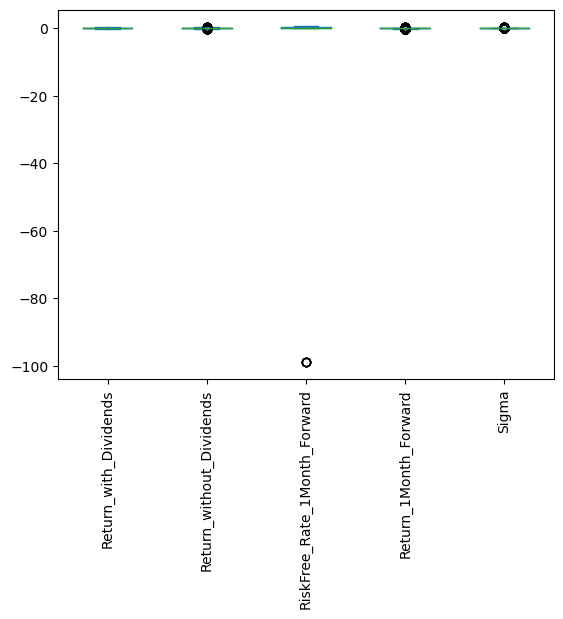

In [10]:
#Plot boxplots

df.plot(kind = 'box')
plt.xticks(rotation = 90)
plt.show()

We observe a severe outlier in `RiskFree_Rate_1Month_Forward`. Since it is almost -100, we can assume this is some measurement error, so to fit a model it will be wise to drop this

In [11]:
#Filter out observations where the foward riskfree rate is greater than 50
df = df.loc[abs(df['RiskFree_Rate_1Month_Forward']) < 50].copy()

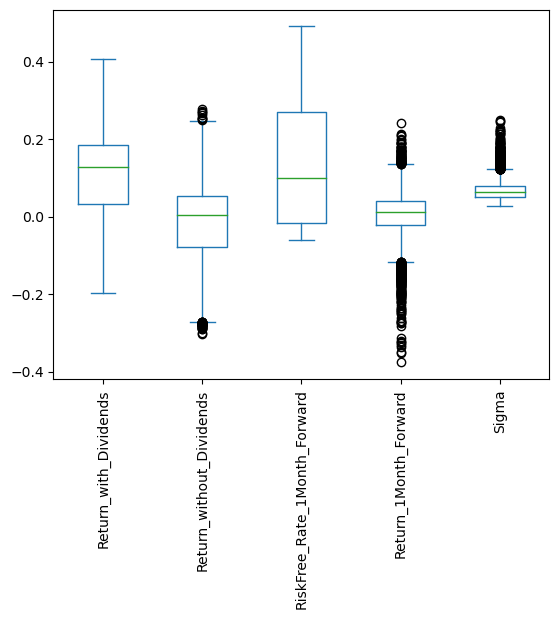

In [12]:
#Plot boxplots

df.plot(kind = 'box')
plt.xticks(rotation = 90)
plt.show()

Despite there still being outliers, these values are within a more reasonable range, and hence this will not effect the generalisation of our model

We now take a look at summary statistics of our data

In [13]:
#Summary statistics
df.describe()

,Return_with_Dividends,Return_without_Dividends,RiskFree_Rate_1Month_Forward,Return_1Month_Forward,Sigma
count,6256.000000,6256.000000,6256.000000,6231.000000,5995.000000
mean,0.109455,-0.012911,0.130775,0.006096,0.069852
std,0.108956,0.096957,0.151515,0.057892,0.027024
min,-0.197034,-0.302599,-0.061559,-0.376489,0.027157
25%,0.031608,-0.077261,-0.015332,-0.022481,0.051304
50%,0.127174,0.005096,0.099123,0.011737,0.064311
75%,0.185965,0.052129,0.269003,0.040565,0.079704
max,0.406503,0.277510,0.490552,0.240728,0.248792


Notably, we see that `Return_without_Dividends` has a negative mean, which implies that on average the value from the past year of the equity excluding dividends actually decreases. From this we can deduce that on average dividends plays a more important role in the value of the equity year on year

## Data Augmentation

We now wish to construct the variables $\Delta d_t$ and $PD_t$. Using the derivations from Question A.1, we have the following:

$$
    PD_t = \frac{V_t + 1}{H_t - V_t}
$$

$$
  \Delta d_t = \log \left ( (H_t - V_t)(V_{t-1} + 1 ) \right) - \log \left ( H_{t-1} - V_{t-1} \right)
$$

### Price-to-Dividend Ratio $PD_t$

In order to calculate the Price-to-Dividend ratio, we can simply augment the dataframe `df` to calculate this value given the formula. 

In [14]:
#Define the H_t and V_t columns
H_t = df["Return_with_Dividends"]
V_t = df["Return_without_Dividends"]

#Augment a column PD_t which applies the relevant function
df['PD_t'] = (V_t+1)/(H_t - V_t)

### Log dividend growth $\Delta d_t$

We can again apply the formula for $\Delta d_t$ listed above to augment the data.

In [15]:
#Augment a column delta_d which applies the relevant function
df["delta_d"] = np.log((H_t.shift() - V_t.shift())*(V_t+1)) - np.log(H_t - V_t)

### Augmented data

We can now inspect our new, augmented data.

In [16]:
#Print data
df.head()

,Return_with_Dividends,Return_without_Dividends,RiskFree_Rate_1Month_Forward,Return_1Month_Forward,Sigma,PD_t,delta_d
date,,,,,,,
1998-02,0.304277,0.143167,0.350638,0.055277,NaN,7.095540,NaN
1998-02,0.291903,0.154534,0.363007,0.025068,NaN,8.404637,0.303119
1998-02,0.269282,0.179072,0.365795,0.043227,NaN,13.070375,0.585262
1998-02,0.290409,0.160366,0.377143,0.056165,NaN,8.922924,-0.216997
1998-02,0.268346,0.149079,0.350271,0.074432,NaN,9.634514,0.225464


In [17]:
df.dropna(inplace = True)

## Further Exploratory Data Analysis

Before fitting models, we can perform some more exploratory data analysis on our augmented data

In [18]:
#Summary Statistics
df.describe()

,Return_with_Dividends,Return_without_Dividends,RiskFree_Rate_1Month_Forward,Return_1Month_Forward,Sigma,PD_t,delta_d
count,5971.000000,5971.000000,5971.000000,5971.000000,5971.000000,5971.000000,5971.000000
mean,0.102810,-0.018293,0.121496,0.005252,0.069832,8.535103,-0.023104
std,0.105308,0.094029,0.147965,0.056380,0.027029,2.327232,0.249851
min,-0.197034,-0.302599,-0.061559,-0.376489,0.027157,4.440278,-1.404444
25%,0.025011,-0.081317,-0.021998,-0.022905,0.051291,7.051794,-0.175724
50%,0.120728,0.001013,0.076496,0.010877,0.064296,8.063557,-0.015668
75%,0.178863,0.047718,0.250311,0.039029,0.079680,9.408249,0.135393
max,0.406503,0.277510,0.490552,0.211338,0.248792,54.194632,1.160398


Although the Price-to-Dividend ratio has a far larger magnitude than the other predictors, since it is a calculated value from the clean data we will keep it in our models

As given, our team hypothesises that we can predict returns using $PD_t$ and $\Delta d_t$. So we now wish to visualise the relationship between these two variables, to inform model selection.

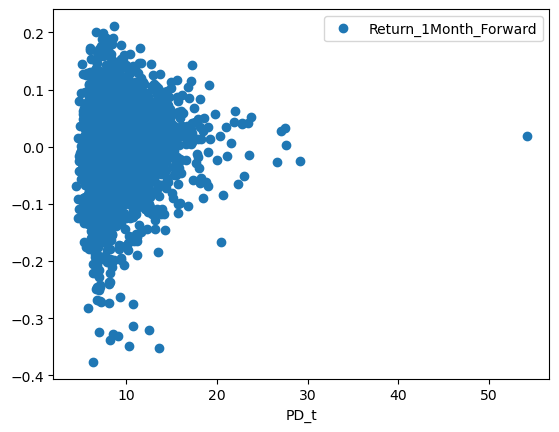

In [19]:
df.plot(x='PD_t', y='Return_1Month_Forward', style='o')
plt.show()

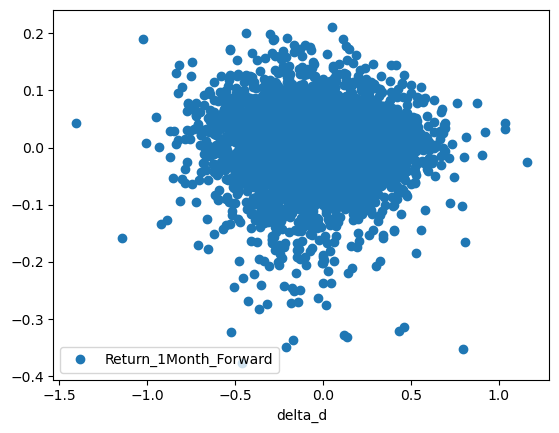

In [20]:
df.plot(x='delta_d', y='Return_1Month_Forward', style='o')
plt.show()

We observe that there may be a small non-linear relationship between $PD_t$ and $R_t$, but there appears to be no discernable relationship between $\Delta d_t$ and $R_t$

We now inspect the considered variable over the time-frame

In [16]:
# df.plot(x='date', y='Return_1Month_Forward')
# plt.show()

KeyError: 'date'

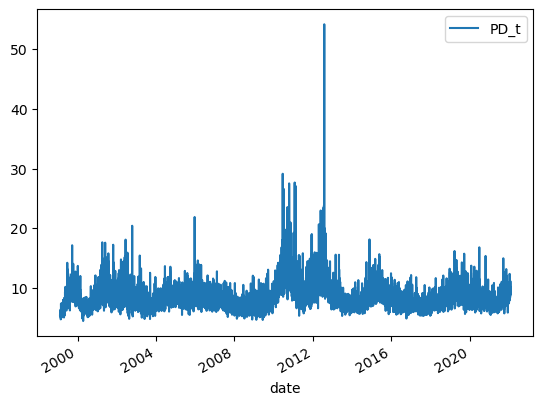

In [70]:
# df.plot(x='date', y='PD_t')
# plt.show()

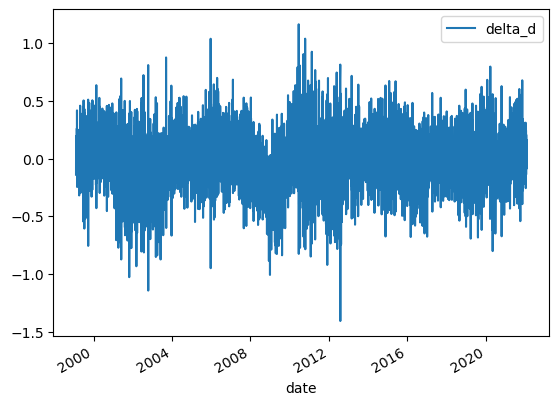

In [71]:
# df.plot(x='date', y='delta_d')
# plt.show()

We can now check autocorrelation plots, 

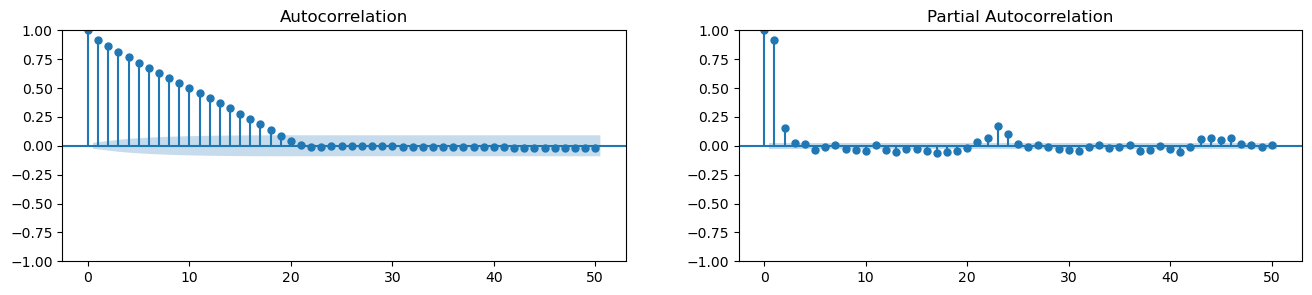

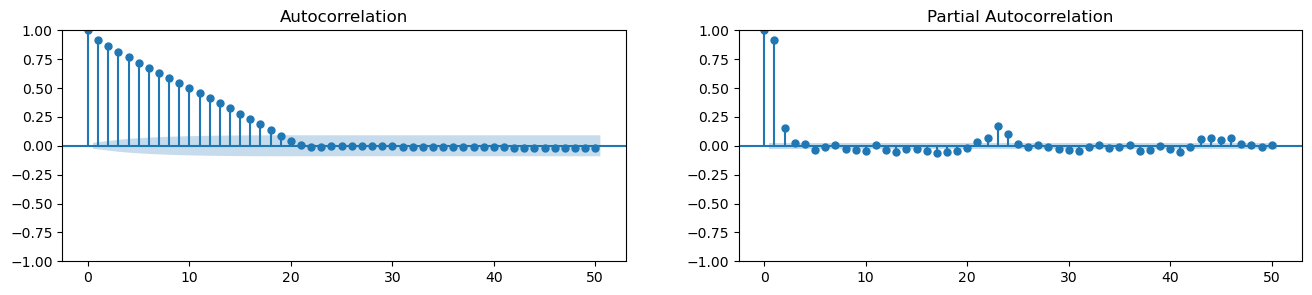

In [42]:
# df ['date'] = df ['date'].apply(mpl_dates.date2num)
# df ['date'] = df ['date'].astype(float)
# autocorrelation_plot(df['date'])
# plt.show()

# fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
# plot_acf(df['Return_1Month_Forward'].tolist(), lags=50, ax=axes[0])
# plot_pacf(df['Return_1Month_Forward'].tolist(), lags=50, ax=axes[1], method = 'ywm')

In [43]:
# fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
# plot_acf(df['Return_1Month_Forward'].tolist(), lags=20, ax=axes[0])
# plot_pacf(df['Return_1Month_Forward'].tolist(), lags=20, ax=axes[1], method = 'ywm')

SyntaxError: incomplete input (3493033192.py, line 3)

## Fitting Models

In order to account for the time-series aspect of the data, we will fit models that account for this. This section documents the construction, fitting, and tuning of the various models

### Train and Validation Split

First we can isolate the variables of interest, namely $R_t$, $PD_t$ and $\Delta d_t$

In [112]:
df_iso = df.loc[:,['Return_1Month_Forward', 'PD_t', 'delta_d']]

Next we want to split our data into a train and validation set, we use a 0.8/0.2 split.

In [132]:
train = df_iso[:int(0.8*(len(df)))]
valid = df_iso[int(0.2*(len(df))):]

In [133]:
train

,Return_1Month_Forward,PD_t,delta_d
date,,,
1999-02,-0.021283,5.447025,-0.140135
1999-02,-0.034798,5.813693,0.131926
1999-02,-0.067520,5.482507,0.004190
1999-02,-0.045575,5.485589,0.073326
1999-02,-0.041374,5.973561,0.156477
...,...,...,...
2017-06,-0.018832,7.125652,0.132897
2017-06,-0.007089,8.243102,0.186274
2017-07,-0.004496,7.691065,-0.033880


We will also split this set into X and y sets for model fitting.

In [134]:
X_train = train.loc[:,['PD_t', 'delta_d']]
X_valid = valid.loc[:,['PD_t', 'delta_d']]

y_train = train.loc[:,['Return_1Month_Forward']]
y_valid = valid.loc[:,['Return_1Month_Forward']]

### Vector Auto-Regressive Model

Since the data is in a time-series, we want to make use of this as well as the the relevant variables. Due to this, we first fit a Vector Auto-Regressive model.

In order to assess whether this model is appropriate, we need to check the stationarity of our time series data.

In [136]:
PD_t_adf = adfuller(df_iso["PD_t"])
print('ADF Statistic: %f' % PD_t_adf[0])
print('p-value: %f' % PD_t_adf[1])
print('Critical Values:')
for key, value in PD_t_adf[4].items():
     print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.167407
p-value: 0.000748
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [137]:
delta_d_adf = adfuller(df_iso["delta_d"])
print('ADF Statistic: %f' % delta_d_adf[0])
print('p-value: %f' % delta_d_adf[1])
print('Critical Values:')
for key, value in delta_d_adf[4].items():
     print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.097147
p-value: 0.026765
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [138]:
returns_adf = adfuller(df_iso['Return_1Month_Forward'])
print('ADF Statistic: %f' % returns_adf[0])
print('p-value: %f' % returns_adf[1])
print('Critical Values:')
for key, value in returns_adf[4].items():
     print('\t%s: %.3f' % (key, value))

ADF Statistic: -10.891709
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


Our null-hypothesis is that the data is not stationary, and since in each variable he ADF statistic is lower than the 5% significance level, we can reject the null hypothesis in each case. This implies our data is sufficiently stationary

We now fit the model to the training set

In [139]:
var = VAR(endog=train)
var_fit = var.fit()

In [140]:
var_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 13, Jun, 2023
Time:                     13:25:29
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -10.1802
Nobs:                     4775.00    HQIC:                  -10.1908
Log likelihood:           4029.84    FPE:                3.73008e-05
AIC:                     -10.1965    Det(Omega_mle):     3.72072e-05
--------------------------------------------------------------------
Results for equation Return_1Month_Forward
                              coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------
const                           -0.000634         0.001393           -0.455           0.649
L1.Return_1Month_Forward         0.913352         0.005894          154.974           0.000


To assess performance, we make predictions on the testing set.

In [141]:
var_prediction = var_fit.forecast(var_fit.endog, steps=len(valid))

In [142]:
cols = df_iso.columns
var_pred = pd.DataFrame(index=range(0,len(var_prediction)),columns=[cols])
for j in range(0,3):
    for i in range(0, len(var_prediction)):
        var_pred.iloc[i][j] = var_prediction[i][j]

np.sqrt(mean_squared_error(var_pred['Return_1Month_Forward'], valid['Return_1Month_Forward']))

0.0538241202854903

For comparison, we also take the AIC score.

In [143]:
print(var_fit.aic)

-10.196495864304282


### Gradient Boosting Machine

In order to capture any non-linear relations, and to iteratively improve the fitness of the model.

We use a grid search cross-validation procedure to tune the model. We define a selection of standard values for the number of trees, the learning rate, the training subsample size for each tree, and the max depth of each tree

In [49]:
grid = dict()
grid['n_estimators'] = [10,50, 100]
grid['learning_rate'] = [0.1, 0.01, 0.001]
grid['subsample'] = [0.5, 0.7, 1.0]
grid['max_depth'] = [3,7, 9]

In [ ]:
grid_search = GridSearchCV(estimator=gbm, param_grid=grid, n_jobs=-1, cv=cv, scoring='neg_mean_squared_error')

grid_result = grid_search.fit(X_train, y_train.values.ravel())

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_)

We see from the output the optimal hyperparameters, and as such we fit a model according to these specifications

In [124]:
gbm = GradientBoostingRegressor(learning_rate = 0.01, n_estimators = 100, subsample = 0.5, max_depth = 3)
gbm_fit = gbm.fit(X_train_std, y_train.values.ravel())

In [126]:
gbm_predict = gbm.predict(X_valid_std)
np.sqrt(mean_squared_error(gbm_predict, y_valid))

0.05512498887833389

### LSTM Model

Lastly, we implement a LSTM Neural Network that will again aim to extract the time-series data. We first scale our data

In [146]:
minmax = MinMaxScaler()
minmax = minmax.fit(train)

train_lstm = train.reshape(train.shape[0], train.shape[1])

AttributeError: 'DataFrame' object has no attribute 'reshape'

In [102]:
normaliser = MinMaxScaler()

train_normalised_data = normaliser.fit_transform(train)

test_normalised_data = normaliser.transform(valid)

In [103]:
history_points = 1

X_train = np.array([train_normalised_data[i : i + history_points].copy() for i in range(len(train_normalised_data) - history_points)])

y_train = np.array([train_normalised_data[:,0][i + history_points].copy() for i in range(len(train_normalised_data) - history_points)])

X_test = np.array([test_normalised_data[i : i + history_points].copy() for i in range(len(test_normalised_data) - history_points)])

y_test = np.array([test_data[:,0][i + history_points].copy() for i in range(len(test_normalised_data) - history_points)])

In [104]:
y_normaliser = MinMaxScaler()

y_test_norm = np.expand_dims(y_test, -1)

y_normalised = y_normaliser.fit(y_test_norm)

In [105]:
lstm_input = Input(shape=(history_points, 3), name='lstm_input')
inputs = LSTM(1, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)

output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)

adam = optimizers.Adam()

model.compile(optimizer=adam, loss='mse')

model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)

Epoch 1/30
287/287 [==============================] - 3s 4ms/step - loss: 0.1179 - val_loss: 0.0121
Epoch 2/30
287/287 [==============================] - 1s 2ms/step - loss: 0.0106 - val_loss: 0.0067
Epoch 3/30
287/287 [==============================] - 1s 2ms/step - loss: 0.0096 - val_loss: 0.0064
Epoch 4/30
287/287 [==============================] - 1s 2ms/step - loss: 0.0090 - val_loss: 0.0059
Epoch 5/30
287/287 [==============================] - 1s 2ms/step - loss: 0.0083 - val_loss: 0.0054
Epoch 6/30
287/287 [==============================] - 1s 2ms/step - loss: 0.0075 - val_loss: 0.0049
Epoch 7/30
287/287 [==============================] - 1s 2ms/step - loss: 0.0067 - val_loss: 0.0043
Epoch 8/30
287/287 [==============================] - 0s 2ms/step - loss: 0.0058 - val_loss: 0.0037
Epoch 9/30
287/287 [==============================] - 0s 2ms/step - loss: 0.0050 - val_loss: 0.0032
Epoch 10/30
287/287 [==============================] - 1s 2ms/step - loss: 0.0043 - val_loss: 0.0027

In [106]:
y_pred = model.predict(X_test)

38/38 [==============================] - 0s 2ms/step


In [107]:
y_pred = y_normaliser.inverse_transform(y_pred)

In [109]:
print(mean_squared_error(y_test, y_pred))

0.025339087555953356


### Linear Regression

In [140]:
X = df[['PD_t', 'delta_d']]
y = df['Return_1Month_Forward']
model = LinearRegression().fit(X,y)

In [142]:
print(f"coefficient of determination: {model.score(X,y)}")
print(f"intercept: {model.intercept_}")
print(f"coefficients: {model.coef_}")

coefficient of determination: 0.0015781006173752887
intercept: -0.0037632647933491152
coefficients: [ 0.00105069 -0.00206148]


By the low coefficient of determination, we observe that this model is extremely poor